In [1]:
%pylab inline

import scipy.ndimage as ndi

%load_ext autoreload
%autoreload 2
from pyotf.otf import SheppardPSF, HanserPSF
import dphtools.display as dplt
from dphtools.utils import bin_ndarray

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.set_cmap("inferno");

<Figure size 432x288 with 0 Axes>

## Is the PSF generated by `pyotf` what the camera sees?

#### Short answer

Not quite.

#### Long answer

What `pyotf` is modeling is the _wavefront_ at the camera due to a point source at the focus of the objective in a widefield [epifluorescence](https://en.wikipedia.org/wiki/Fluorescence_microscope#Epifluorescence_microscopy) (AKA, widefield or epi) microscope. But what the camera _records_ is more complex. First, each pixel acts a a square aperture (similar to the circular aperture in confocal microscopy) and then the intensity across the pixel is integrated and eventually converted into a single number. To model this we'll take the following approach:
1. Use `pyotf` to model the _intensity_ point spread function (PSF) at the camera at a pixel size of $1/8^{\text{th}}$ Nyquist, i.e. $\lambda/4 \text{NA}/8$
2. Convolve this image with a square equal to the size of the camera pixel
3. Integrate over the camera pixels

In [3]:
# We'll use a 1.27 NA water dipping objective imaging in water
psf_params = dict(
    na=1.27,
    ni=1.33,
    wl=0.585,
    size=64,
    vec_corr="none",
    zrange=[0]
)

# Set the Nyquist sampling rate
nyquist_sampling = psf_params["wl"] / psf_params["na"] / 4

# our oversampling factor
oversample_factor = 8

# we need to be just slightly less than nyquist for this to work
psf_params["res"] = nyquist_sampling * 0.99 / oversample_factor
psf_params["size"] *= oversample_factor

In [4]:
# calculate infocus part only
psf = HanserPSF(**psf_params)

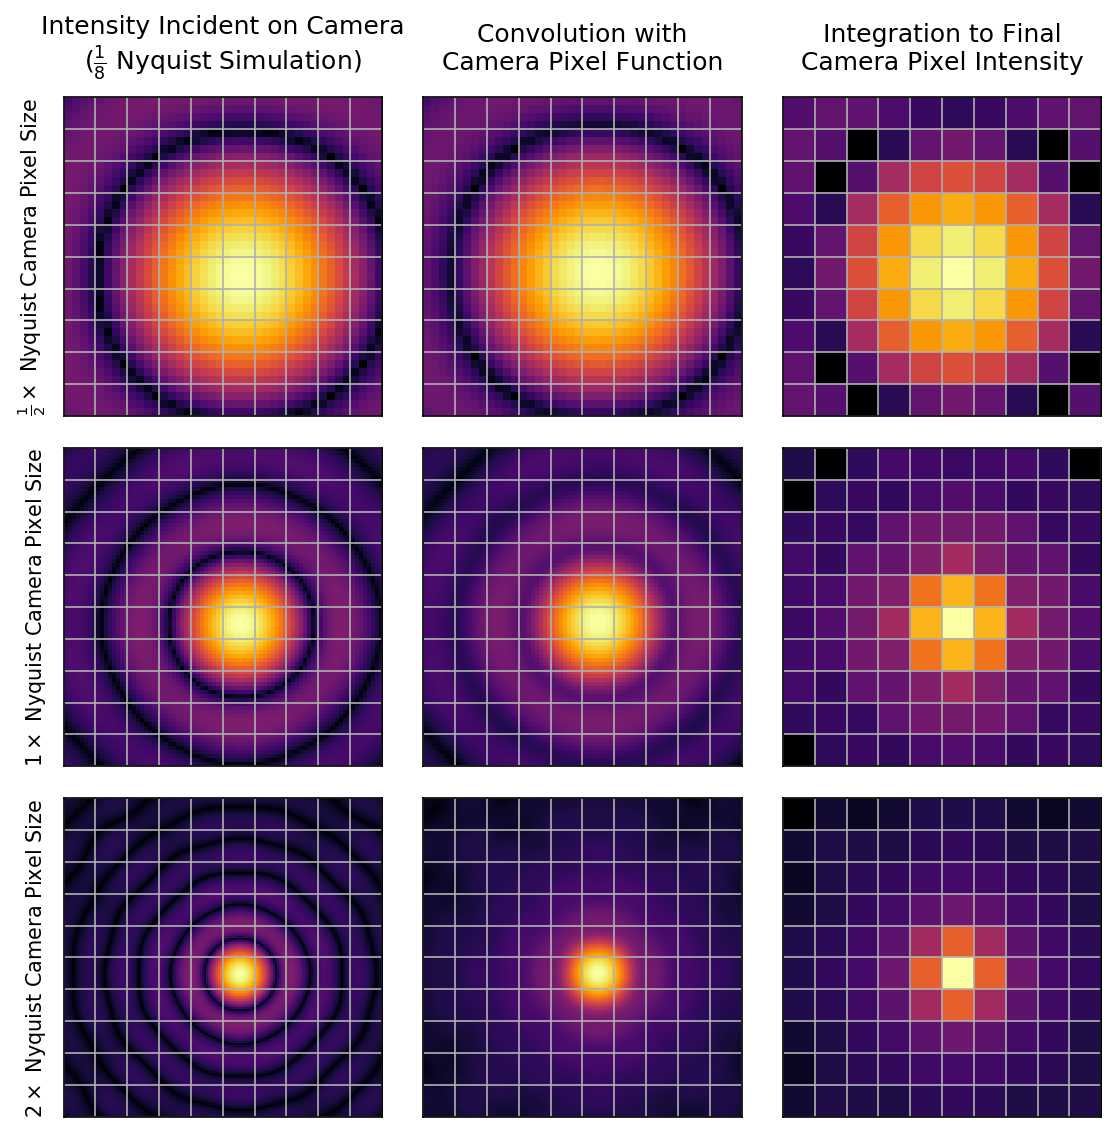

In [5]:
# for each camera pixel size we want to show 10 camera pixels worth of the intensity
num_pixels = 10

# gamma for display
gam = 0.3

# set up the figure
fig, axs_total = plt.subplots(3, 3, dpi=150, figsize=(9,9), gridspec_kw=dict(hspace=0.1, wspace=0.1))

# rows will be for different camera pixel sizes, the camera pixel size = subsample / 8 * Nyquist
for axs, subsample in zip(axs_total, (4, 8, 16)):

    # for display zoom in
    offset = (len(psf.PSFi.squeeze()) - num_pixels * subsample) // 2

    # show the original data, shifted such that the max is at the center of the
    # camera ROI
    axs[0].matshow(psf.PSFi.squeeze()[offset-subsample//2:-offset-subsample//2, offset-subsample//2:-offset-subsample//2],
                   norm=mpl.colors.PowerNorm(gam))

    # Use the convolution to shift the data so that the max is centered on camera ROI
    origin_shift = subsample // 2 - 1
    exact = ndi.uniform_filter(psf.PSFi[0], subsample, origin=origin_shift)
    
    # Show convolved data
    axs[1].matshow(exact[offset:-offset, offset:-offset], norm=mpl.colors.PowerNorm(gam))
    for ax in axs[:2]:
        ax.xaxis.set_major_locator(plt.FixedLocator(np.arange(0, offset, subsample) - 0.5))
        ax.yaxis.set_major_locator(plt.FixedLocator(np.arange(0, offset, subsample) - 0.5))
    
    # integrate across pixel
    exact_subsample = bin_ndarray(exact, bin_size=subsample, operation="sum")

    # Display final camera pixels
    offset_sub = offset//subsample
    ax = axs[-1]
    ax.matshow(exact_subsample[offset_sub:-offset_sub, offset_sub:-offset_sub], norm=mpl.colors.PowerNorm(gam))
    ax.xaxis.set_major_locator(plt.FixedLocator(np.arange(0, offset_sub) - 0.5))
    ax.yaxis.set_major_locator(plt.FixedLocator(np.arange(0, offset_sub) - 0.5))

    # clean up plot
    for ax in axs:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.tick_params(length=0)
        ax.grid(True)
        
# label
axs_total[0, 0].set_title("Intensity Incident on Camera\n($\\frac{1}{8}$ Nyquist Simulation)")
axs_total[0, 1].set_title("Convolution with\nCamera Pixel Function")
axs_total[0, 2].set_title("Integration to Final\nCamera Pixel Intensity")

axs_total[0, 0].set_ylabel(r"$\frac{1}{2}\times$ Nyquist Camera Pixel Size")
axs_total[1, 0].set_ylabel(r"$1\times$ Nyquist Camera Pixel Size")
axs_total[2, 0].set_ylabel(r"$2\times$ Nyquist Camera Pixel Size");

The above figure shows each of the three steps (columns) for three different camera pixels sizes (rows). Gray lines indicate the final camera pixel grid. It's clear that the convolution has an effect on camera pixel sizes larger than Nyquist. Considering that we usually ask microscopists to image at Nyquist and therefore we usually model PSFs at Nyquist a natural question is: how different are the higher resolution calculations (such as in the figure above) from simulating directly with Nyquist sized camera pixels? Furthermore, when simulating PSFs for camera pixels that are larger than Nyquist, how important is the convolution operation (step 2)?

It's safe to assume that the area with the highest resolution will be most effected and thus we can limit our investigations to the 2D infocus PSF.

In [6]:
# keep our original parameters safe
psf_params_wf = psf_params.copy()

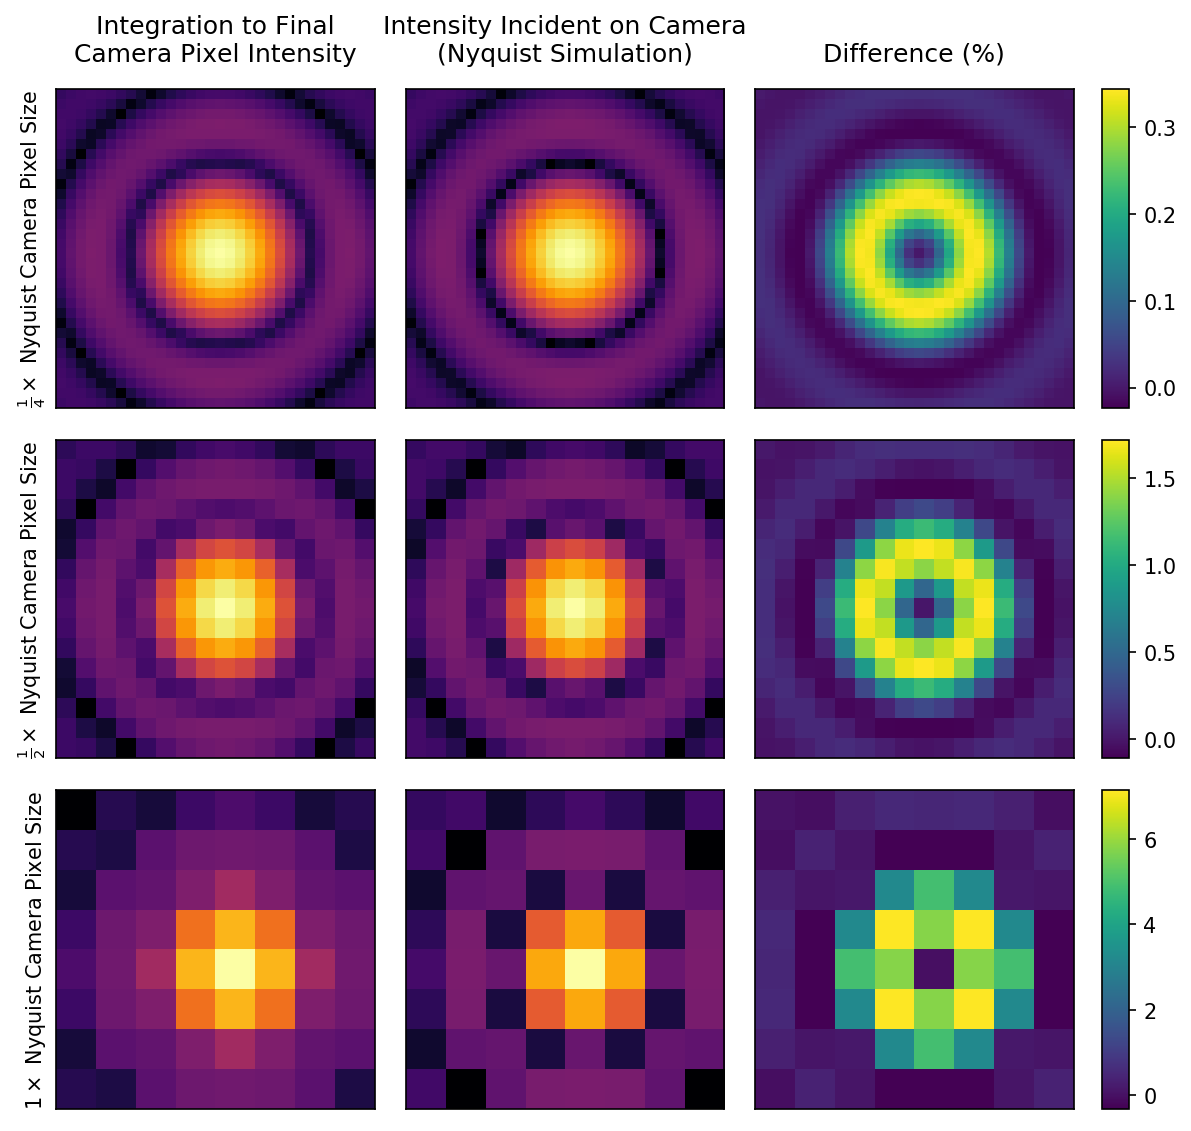

In [7]:
# for each camera pixel size we want to show 10 camera pixels worth of the intensity
num_pixels = 64

# set up the figure
fig, axs_total = plt.subplots(3, 4, dpi=150, figsize=(9.25, 9),
                              gridspec_kw=dict(hspace=0.1, wspace=0.1, width_ratios=(1, 1, 1, 1 / 12)))

# rows will be for different camera pixel sizes, the camera pixel size = subsample / 8 * Nyquist
for axs, subsample in zip(axs_total, (2, 4, 8)):

    # for display zoom in
    offset = (len(psf.PSFi.squeeze()) - num_pixels) // 2

    # show the original data, shifted such that the max is at the center of the
    # camera ROI
    # axs[0].matshow(psf.PSFi.squeeze()[offset-subsample//2:-offset-subsample//2, offset-subsample//2:-offset-subsample//2],
    #                norm=mpl.colors.PowerNorm(gam))

    # Use the convolution to shift the data so that the max is centered on camera ROI
    origin_shift = subsample // 2 - 1
    exact = ndi.uniform_filter(psf.PSFi[0], subsample, origin=origin_shift)
    
    # Show convolved data
    # axs[1].matshow(exact[offset:-offset, offset:-offset], norm=mpl.colors.PowerNorm(gam))
    
    # integrate across pixel
    exact_subsample = bin_ndarray(exact, bin_size=subsample, operation="sum")
    exact_subsample /= exact_subsample.max()

    # Display final camera pixels
    offset_sub = offset//subsample
    axs[0].matshow(exact_subsample[offset_sub:-offset_sub, offset_sub:-offset_sub], norm=mpl.colors.PowerNorm(gam))

    # Directly simulate at Nyquist
    psf_params_wf['res'] = psf_params['res'] * subsample
    psf_params_wf['size'] = psf_params['size'] // subsample
    low_res = HanserPSF(**psf_params_wf).PSFi.squeeze()
    low_res /= low_res.max()
    
    # display direct simulation
    axs[1].matshow(low_res[offset_sub:-offset_sub, offset_sub:-offset_sub], norm=mpl.colors.PowerNorm(gam))
    
    # Calculate percent of max difference and display
    difference = (exact_subsample - low_res)
    im = axs[2].matshow(difference[offset_sub:-offset_sub, offset_sub:-offset_sub] * 100, cmap="viridis")
    plt.colorbar(im, ax=axs[2], cax=axs[3])
    
    # clean up plot
    for ax in axs[:3]:
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
        
# label
axs_total[0, 0].set_title("Integration to Final\nCamera Pixel Intensity")
axs_total[0, 1].set_title("Intensity Incident on Camera\n(Nyquist Simulation)")
axs_total[0, 2].set_title("Difference (%)")

axs_total[0, 0].set_ylabel(r"$\frac{1}{4}\times$ Nyquist Camera Pixel Size")
axs_total[1, 0].set_ylabel(r"$\frac{1}{2}\times$ Nyquist Camera Pixel Size")
axs_total[2, 0].set_ylabel(r"$1\times$ Nyquist Camera Pixel Size");

Presented in the figure above is a comparison of the "exact" simulation (first column) to the "direct" simulation (second column), the difference is shown in the third column. As expected smaller camera pixels result in smaller the differences between the "exact" and "direct" calculations. But even at it's worst (i.e. Nyquist sampling on the camera) the maximum deviation is about 7% of the peak PSF intensity. 

Of course, we know that single numbers are no way to evaluate resolution, or the loss thereof. Therefore we'll take a look in frequency space.

In [8]:
from pyotf.utils import easy_fft
from dphtools.utils import radial_profile

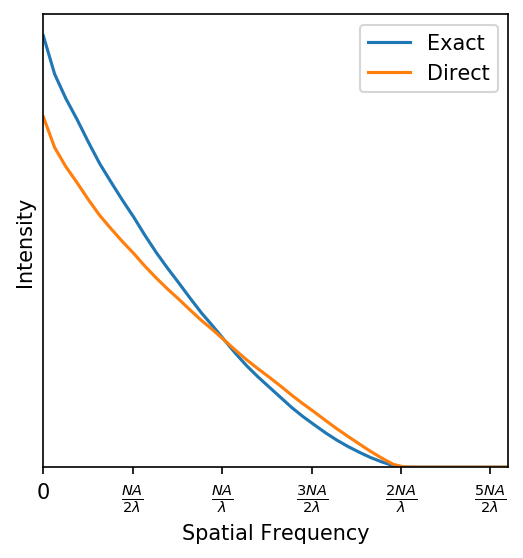

In [9]:
fig, ax = plt.subplots(figsize=(4,4), dpi=150)

k_pixel_size = 2 / psf_params_wf["res"] / len(exact_subsample)
abbe_limit = 1 / nyquist_sampling / k_pixel_size

for l, d in zip(("Exact", "Direct"), (exact_subsample, low_res)):
    o = abs(easy_fft(d))
    ro = radial_profile(o)[0]
    ax.plot(np.arange(len(ro)) / abbe_limit * 2, ro, label=l)

ax.legend()
ax.set_xlabel("Spatial Frequency")
ax.set_ylabel("Intensity")
ax.set_xlim(0, 2.6)
ax.set_ylim(0)
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.MultipleLocator(1 / 2))

def formatter(x, pos):
    if x == 0:
        return 0
    if x / 0.5 % 2:
        x = int(x) * 2 + 1
        if x == 1:
            x = ""
        return r"$\frac{{{}NA}}{{2\lambda}}$".format(x)
    elif int(x):
        x = int(x)
        if x == 1:
            x = ""
        return r"$\frac{{{}NA}}{{\lambda}}$".format(x)
    return r"$\frac{NA}{\lambda}$"
    
ax.xaxis.set_major_formatter(plt.FuncFormatter(formatter))

We see (figure above) that the exact simulation, which includes convolution and then integration, redistributes the OTF support slightly towards the DC component, which makes sense as both convolution and integration will blur high frequency information. Note that the OTF cutoff remains nearly the same in both cases: $2 NA / \lambda$.

What about PSFs for large camera pixels? We follow the exact same procedure as above.

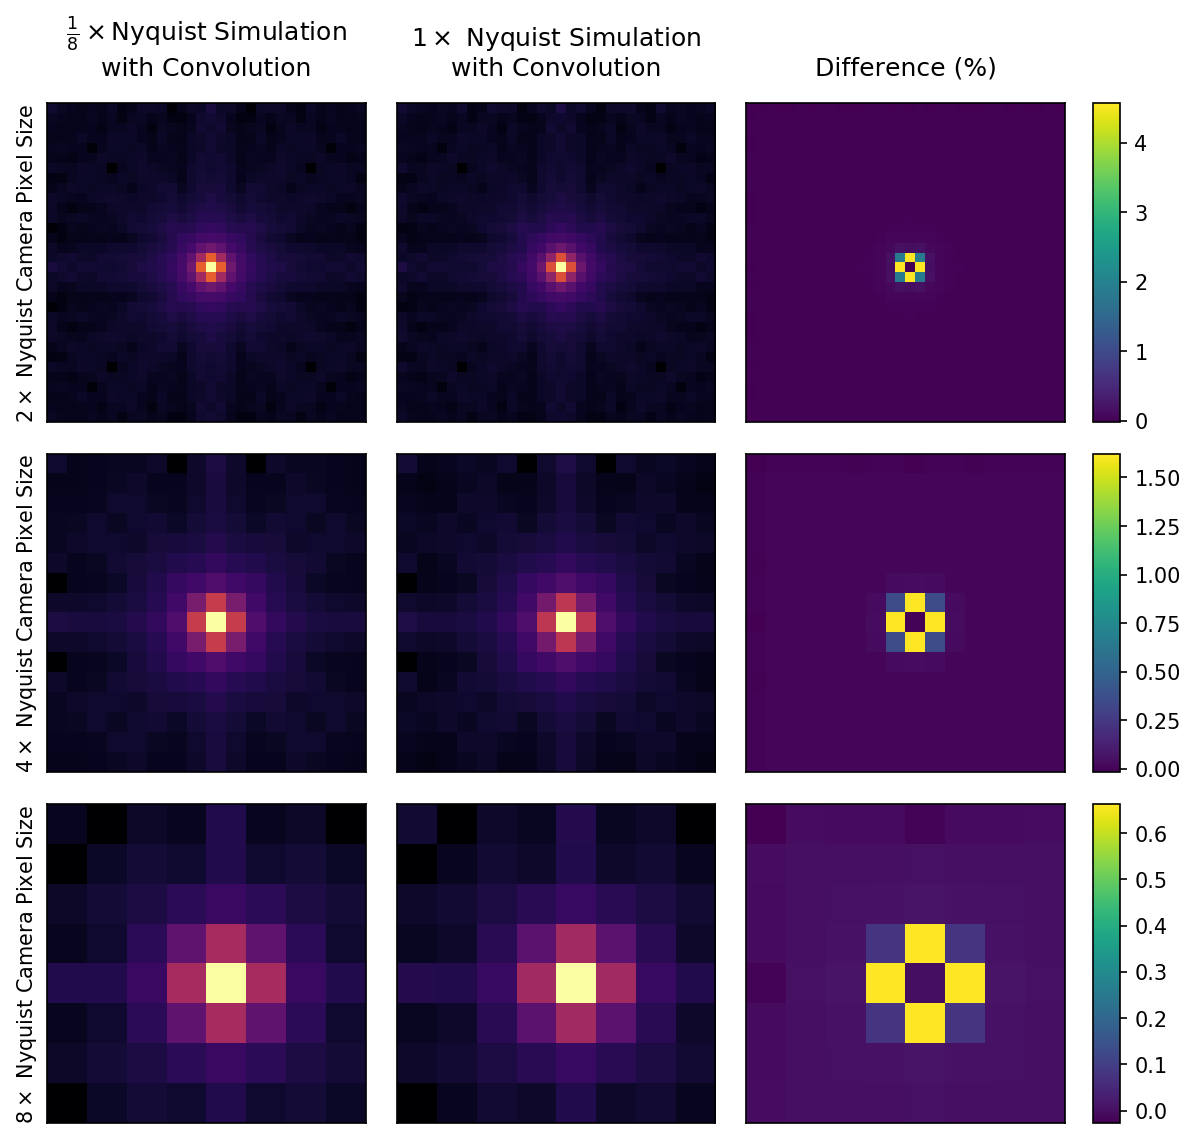

In [10]:
# for each camera pixel size we want to show 10 camera pixels worth of the intensity
num_pixels = len(psf.PSFi.squeeze())

# Directly simulate at Nyquist
psf_params_wf['res'] = psf_params['res'] * oversample_factor
psf_params_wf['size'] = psf_params['size'] // oversample_factor
low_res = HanserPSF(**psf_params_wf).PSFi.squeeze()

# set up the figure
fig, axs_total = plt.subplots(3, 4, dpi=150, figsize=(9.25,9),
                              gridspec_kw=dict(hspace=0.1, wspace=0.1, width_ratios=(1, 1, 1, 1 / 12)))

# rows will be for different camera pixel sizes, the camera pixel size = subsample / 8 * Nyquist
for axs, subsample in zip(axs_total[::-1], (8, 4, 2)):
    
    subsample2 = oversample_factor * subsample
    # for display zoom in
    offset = (len(psf.PSFi.squeeze()) - num_pixels) // 2

    # show the original data, shifted such that the max is at the center of the
    # camera ROI
    # axs[0].matshow(psf.PSFi.squeeze(), norm=mpl.colors.PowerNorm(gam))

    # Use the convolution to shift the data so that the max is centered on camera ROI
    origin_shift2 = subsample2 // 2 - 1
    exact = ndi.uniform_filter(psf.PSFi[0], subsample2, origin=origin_shift2)
    
    # Show convolved data
    # axs[1].matshow(exact, norm=mpl.colors.PowerNorm(gam))
    
    # integrate across pixel
    exact_subsample = bin_ndarray(exact, bin_size=subsample2, operation="sum")
    exact_subsample /= exact_subsample.max()

    # Display final camera pixels
    offset_sub = offset//subsample2
    axs[0].matshow(exact_subsample, norm=mpl.colors.PowerNorm(gam))

    origin_shift = subsample // 2 - 1
    exact_low_res = ndi.uniform_filter(low_res, subsample, origin=origin_shift)
    exact_low_res_subsample = bin_ndarray(exact_low_res, bin_size=subsample, operation="sum")
    exact_low_res_subsample /= exact_low_res_subsample.max()
    
    low_res_subsample = bin_ndarray(low_res, bin_size=subsample, operation="sum")
    low_res_subsample /= low_res_subsample.max()
    
    # display direct simulation
    axs[1].matshow(exact_low_res_subsample, norm=mpl.colors.PowerNorm(gam))
    
    # Calculate percent of max difference and display
    difference = (exact_subsample - exact_low_res_subsample)
    im = axs[2].matshow(difference * 100, cmap="viridis")
    plt.colorbar(im, ax=axs[2], cax=axs[3])
    
    # clean up plot
    for ax in axs[:3]:
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
        
# label
axs_total[0, 0].set_title(r"$\frac{1}{8}\times$" + "Nyquist Simulation\nwith Convolution")
axs_total[0, 1].set_title(r"$1\times$ " + "Nyquist Simulation\nwith Convolution")
axs_total[0, 2].set_title("Difference (%)")

axs_total[0, 0].set_ylabel(r"$2\times$ Nyquist Camera Pixel Size")
axs_total[1, 0].set_ylabel(r"$4\times$ Nyquist Camera Pixel Size")
axs_total[2, 0].set_ylabel(r"$8\times$ Nyquist Camera Pixel Size");

As expected, the larger the final camera pixel size the smaller the relative difference in simulation pixel size and thus the smaller the difference in the simulations. Now for the question of whether the convolution step is even necessary when looking at camera pixels larger than Nyquist.

First note that without convolution to redistribute the intensity before integration (a kind of interpolation) we won't have a symmetric PSF using an even shaped camera pixel (relative to the simulation pixels). So instead of looking at 2x, 4x, and 8x camera pixel sizes like we've been doing above we'll use odd sizes of 3x, 5x and 9x. As a sanity check let's look at the difference between the two methods with no convolution step for either. The result is a measure of the integration error between a finer and coarser integration grid.

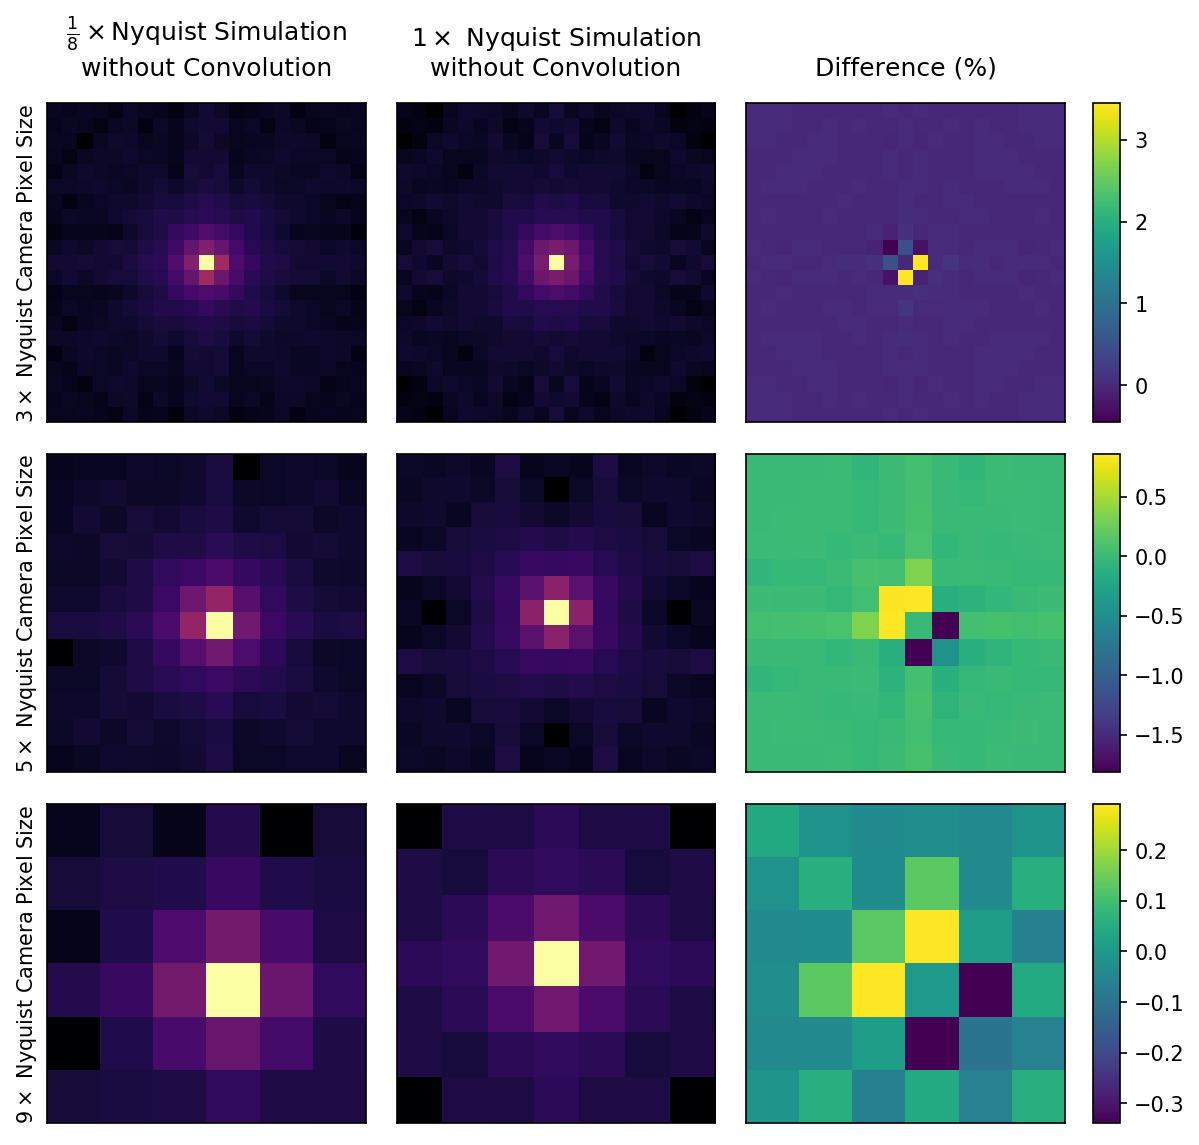

In [11]:
# set up the figure
fig, axs_total = plt.subplots(3, 4, dpi=150, figsize=(9.25,9),
                              gridspec_kw=dict(hspace=0.1, wspace=0.1, width_ratios=(1, 1, 1, 1 / 12)))

# rows will be for different camera pixel sizes, the camera pixel size = subsample / 8 * Nyquist
for axs, subsample in zip(axs_total[::-1], (9, 5, 3)):
    # Directly simulate at Nyquist
    psf_params_wf['res'] = psf_params['res'] * oversample_factor
    c = np.log2(subsample) % 2
    if c < 1:
        c = 1
    else:
        c = -1
    psf_params_wf['size'] = psf_params['size'] // oversample_factor + c
    low_res = HanserPSF(**psf_params_wf).PSFi.squeeze()
    
    subsample2 = oversample_factor * subsample

    # Use the convolution to shift the data so that the max is centered on camera ROI
    shift = len(psf.PSFi[0])%subsample + 1
    shifted = psf.PSFi[0, shift:, shift:]
    exact = ndi.uniform_filter(shifted, subsample2)
    
    # integrate across pixel
    exact_subsample = bin_ndarray(shifted, bin_size=subsample2, operation="sum")
    exact_subsample /= exact_subsample.max()

    # Display final camera pixels
    offset_sub = offset//subsample2
    axs[0].matshow(exact_subsample, norm=mpl.colors.PowerNorm(gam))

    exact_low_res = ndi.uniform_filter(low_res, subsample)
    exact_low_res_subsample = bin_ndarray(exact_low_res, bin_size=subsample, operation="sum")
    exact_low_res_subsample /= exact_low_res_subsample.max()
    
    low_res_subsample = bin_ndarray(low_res, bin_size=subsample)
    low_res_subsample /= low_res_subsample.max()
    
    # display direct simulation
    axs[1].matshow(low_res_subsample, norm=mpl.colors.PowerNorm(gam))
    
    # Calculate percent of max difference and display
    lexact = len(exact_subsample)
    llow = len(low_res_subsample)
    if lexact <= llow:
        difference = (exact_subsample - low_res_subsample[:lexact, :lexact])
    else:
        difference = (exact_subsample - low_res_subsample[:llow, :llow])
    im = axs[2].matshow(difference * 100, cmap="viridis")
    plt.colorbar(im, ax=axs[2], cax=axs[3])
    
    # clean up plot
    for ax in axs[:3]:
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
        
# label
axs_total[0, 0].set_title(r"$\frac{1}{8}\times$" + "Nyquist Simulation\nwithout Convolution")
axs_total[0, 1].set_title(r"$1\times$ " + "Nyquist Simulation\nwithout Convolution")
axs_total[0, 2].set_title("Difference (%)")

axs_total[0, 0].set_ylabel(r"$3\times$ Nyquist Camera Pixel Size")
axs_total[1, 0].set_ylabel(r"$5\times$ Nyquist Camera Pixel Size")
axs_total[2, 0].set_ylabel(r"$9\times$ Nyquist Camera Pixel Size");

As expected the integration error decreases with increasing camera pixel size. Now to test the effect of convolution on the process.

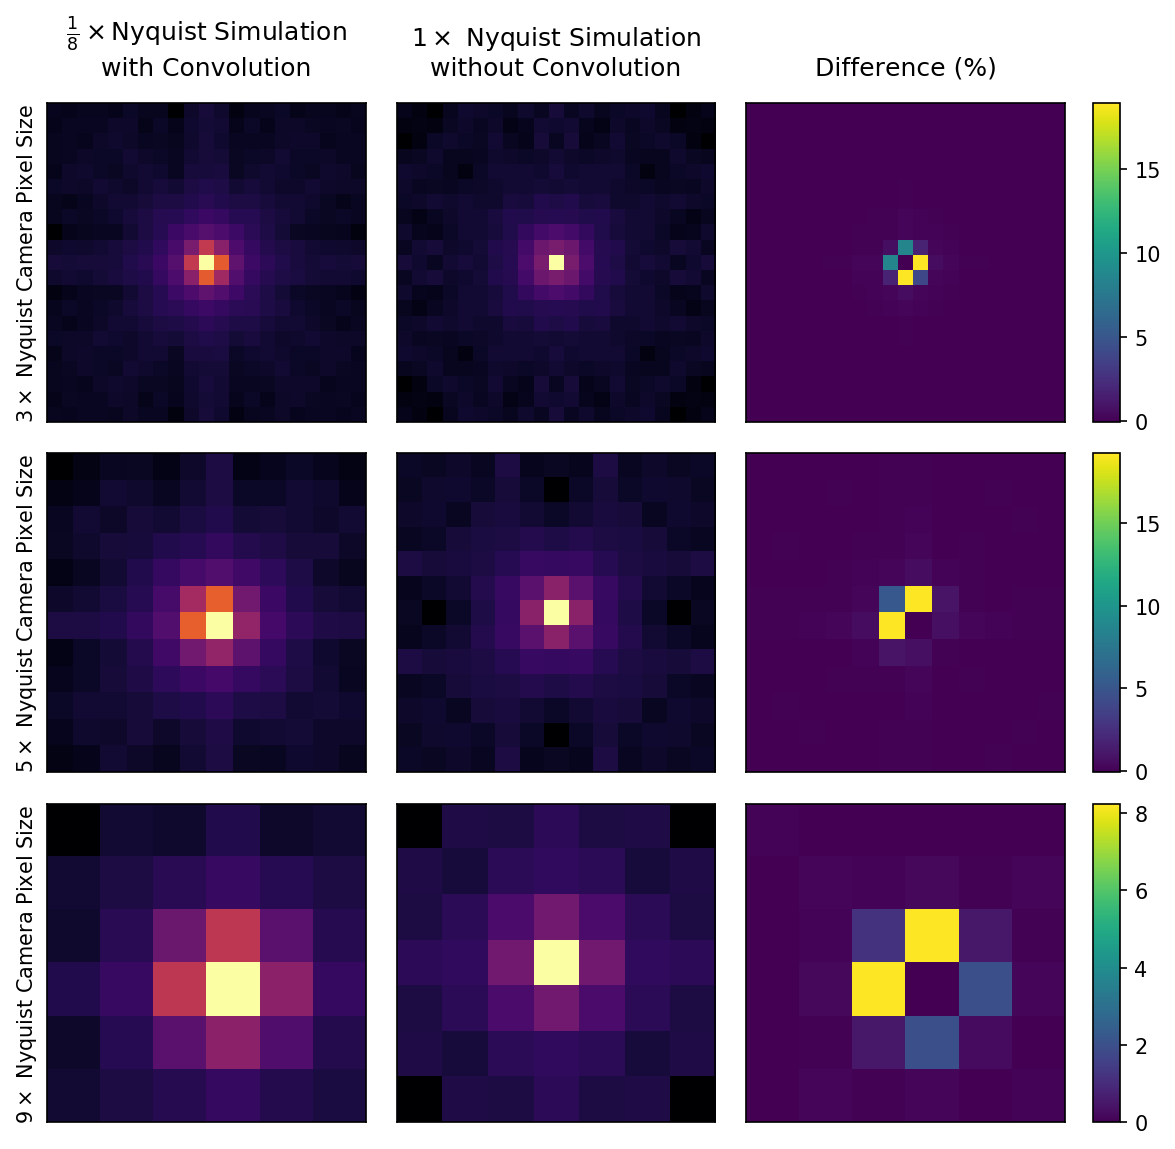

In [12]:
# set up the figure
fig, axs_total = plt.subplots(3, 4, dpi=150, figsize=(9.25,9),
                              gridspec_kw=dict(hspace=0.1, wspace=0.1, width_ratios=(1, 1, 1, 1 / 12)))

# rows will be for different camera pixel sizes, the camera pixel size = subsample / 8 * Nyquist
for axs, subsample in zip(axs_total[::-1], (9, 5, 3)):
    # Directly simulate at Nyquist
    psf_params_wf['res'] = psf_params['res'] * oversample_factor
    c = np.log2(subsample) % 2
    if c < 1:
        c = 1
    else:
        c = -1
    psf_params_wf['size'] = psf_params['size'] // oversample_factor + c
    low_res = HanserPSF(**psf_params_wf).PSFi.squeeze()
    
    subsample2 = oversample_factor * subsample

    # Use the convolution to shift the data so that the max is centered on camera ROI
    shift = len(psf.PSFi[0])%subsample + 1
    shifted = psf.PSFi[0, shift:, shift:]
    exact = ndi.uniform_filter(shifted, subsample2)
    
    # integrate across pixel
    exact_subsample = bin_ndarray(exact, bin_size=subsample2, operation="sum")
    exact_subsample /= exact_subsample.max()

    # Display final camera pixels
    offset_sub = offset//subsample2
    axs[0].matshow(exact_subsample, norm=mpl.colors.PowerNorm(gam))

    exact_low_res = ndi.uniform_filter(low_res, subsample)
    exact_low_res_subsample = bin_ndarray(exact_low_res, bin_size=subsample, operation="sum")
    exact_low_res_subsample /= exact_low_res_subsample.max()
    
    low_res_subsample = bin_ndarray(low_res, bin_size=subsample)
    low_res_subsample /= low_res_subsample.max()
    
    # display direct simulation
    axs[1].matshow(low_res_subsample, norm=mpl.colors.PowerNorm(gam))
    
    # Calculate percent of max difference and display
    lexact = len(exact_subsample)
    llow = len(low_res_subsample)
    if lexact <= llow:
        difference = (exact_subsample - low_res_subsample[:lexact, :lexact])
    else:
        difference = (exact_subsample - low_res_subsample[:llow, :llow])
    im = axs[2].matshow(difference * 100, cmap="viridis")
    plt.colorbar(im, ax=axs[2], cax=axs[3])
    
    # clean up plot
    for ax in axs[:3]:
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
        
# label
axs_total[0, 0].set_title(r"$\frac{1}{8}\times$" + "Nyquist Simulation\nwith Convolution")
axs_total[0, 1].set_title(r"$1\times$ " + "Nyquist Simulation\nwithout Convolution")
axs_total[0, 2].set_title("Difference (%)")

axs_total[0, 0].set_ylabel(r"$3\times$ Nyquist Camera Pixel Size")
axs_total[1, 0].set_ylabel(r"$5\times$ Nyquist Camera Pixel Size")
axs_total[2, 0].set_ylabel(r"$9\times$ Nyquist Camera Pixel Size");

Clearly there's quite a bit of error, up to ~20% of the max value in the worst case. Again we see a decrease in error with increasing camera pixel size. Now turning to the more informative frequency space representation for the 3X Nyquist camera pixels.

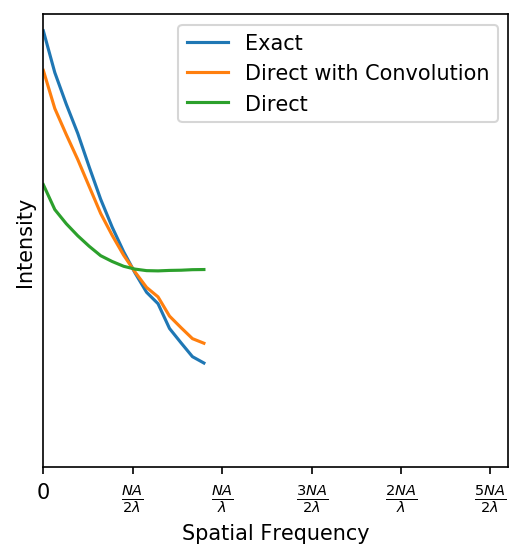

In [13]:
fig, ax = plt.subplots(figsize=(4,4), dpi=150)

k_pixel_size = 2 / psf_params_wf["res"] / len(exact_subsample) / subsample
abbe_limit = 1 / nyquist_sampling / k_pixel_size

for l, d in zip(("Exact", "Direct with Convolution", "Direct"), (exact_subsample, exact_low_res_subsample, low_res_subsample)):
    o = abs(easy_fft(d))
    ro = radial_profile(o)[0]
    ax.plot(np.arange(len(ro)) / abbe_limit * 2, ro, label=l)

ax.legend()
ax.set_xlabel("Spatial Frequency")
ax.set_ylabel("Intensity")
ax.set_xlim(0, 2.6)
ax.set_ylim(0)

ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.MultipleLocator(1 / 2))
ax.xaxis.set_major_formatter(plt.FuncFormatter(formatter))

This is more concerning: if we use convolution our "direct" simulation is reasonably accurate, if we don't the roll-off in transmittence of spatial frequencies is unphysical. If you were to use the "direct" simulation without convolution you might be lead to believe that you could resolve higher frequency information than you could in reality.